# **Data Modelling**

## Objectives

- Business requirement 2:
The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs

- inputs/cherry_leaves_dataset/cherry-leaves/train
- inputs/cherry_leaves_dataset/cherry-leaves/test
- inputs/cherry_leaves_dataset/cherry-leaves/validation
- Image shape embeddings

## Outputs
- Images distribution plot in train, validation, and test set.
- label distribution - bar chart
- set distriburion - pie chart (percentages)
- Image augmentation.
- plot augmented images for each set.
- Class indices to change prediction inference in labels.
- Creation of a Machine learning model and display of its summary
- Model training.
- Save model.
- Learning curve plot for model performance.
- Model A - separate plots for accuracy and loss
- Model B - comprehensive model history plot
- Model C - plot model history with plotly
- Model evaluation on saved file.
- calculate accuracy
- plot ROC curve
- calculate classification report (Model A)
- Model B - classification report with macro avg and weighted avg
- Model C - syntetic classification report per label
- Plot Confusion Matrix
- Save evaluation pickle file
- Prediction on the random image file.

## Additional Comments

- The code in the notebook analyzes the distribution of images across training, validation, and test sets, followed by augmenting these images for training using techniques such as rotation, zoom, and flipping. It defines a convolutional neural network (CNN) model for detecting powdery mildew in cherry leaves, trains it with callbacks for early stopping and model checkpointing, and evaluates its performance using metrics such as accuracy, loss, ROC curve, and confusion matrix. Finally, it saves the trained model, generates classification reports, and predicts the class of new images based on the model’s outputs.



---

# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
from matplotlib.image import imread

# Set Working Directory


In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/mildew-detector-pp5')
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detector-pp5'

# Set Input Directories


Sets the train, test and validation paths

In [9]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'


# Set output directory

In [10]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


 Set Label Names

In [11]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


 Set Image Shape

In [12]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Images Distribution

These plots will give you a comprehensive view of your dataset's distribution across different labels and sets, which is essential for understanding data balance and preparing for model training.

### Count Number of Images per Set & Label


In [13]:
import plotly.express as px

df_freq = pd.DataFrame([])
for folder in ['train', 'test', 'validation']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Count': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images




## Label Distribution - Bar Chart

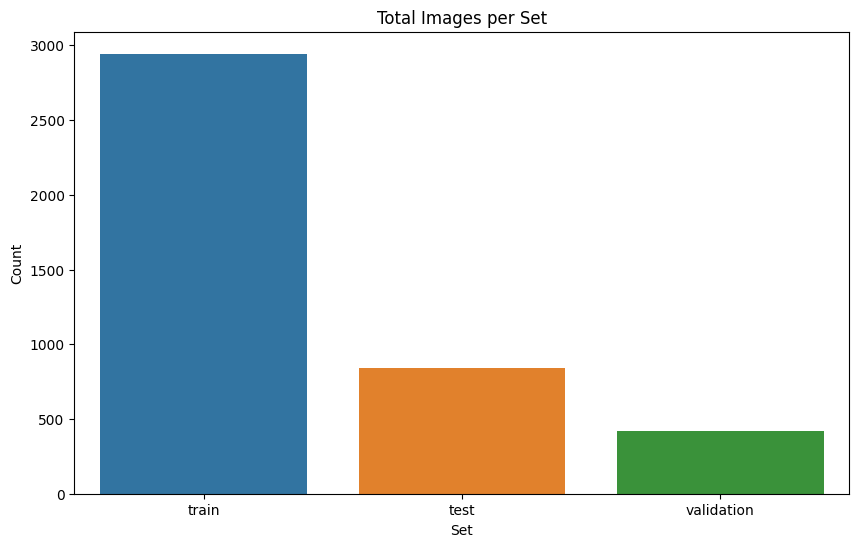

In [10]:

plt.figure(figsize=(10, 6))
sns.barplot(data=df_freq, x='Set', y='Count', estimator=sum, ci=None)
plt.title('Total Images per Set')
plt.xlabel('Set')
plt.ylabel('Count')
plt.savefig(f'{file_path}/sets_distribution_bar.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Set Distribution - Pie Chart

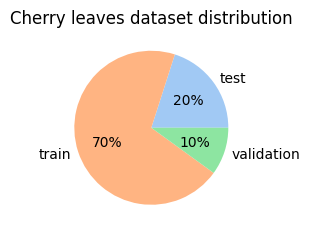

In [11]:
folders = os.listdir(my_data_dir)
data=[]
for folder in folders:
    for label in labels:
        n=int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        n+=n
    data.append(n)

px = 1/plt.rcParams['figure.dpi'] 
plt.subplots(figsize=(800*px, 250*px))
colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels = folders, colors = colors, autopct='%.0f%%')
plt.title('Cherry leaves dataset distribution')
plt.savefig(f'{file_path}/sets_distribution_pie.png',
            bbox_inches='tight', dpi=150)
plt.show()


---


# Image Data Augmentation


 Import ImageDataGenerator

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Initialize ImageDataGenerator

In [16]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

Set Batch Size

In [17]:
batch_size = 16

Augment Training Image Set

In [18]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Plot Augmented Training Image Set

(16, 256, 256, 3)


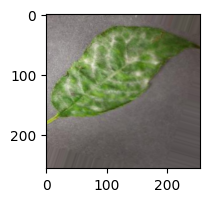

(16, 256, 256, 3)


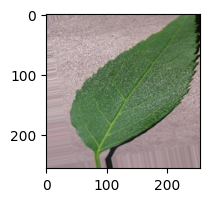

(16, 256, 256, 3)


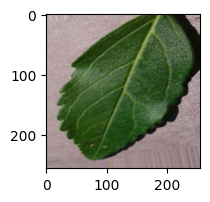

In [19]:
%matplotlib inline
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()


Augment Validation Image Set

In [20]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Plot Augmented Validation Image Set

(16, 256, 256, 3)


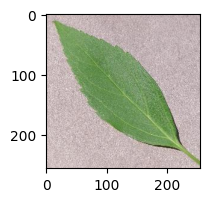

(16, 256, 256, 3)


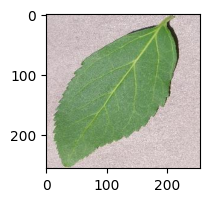

(16, 256, 256, 3)


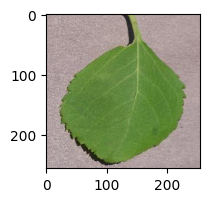

In [21]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

Augment Test Image Set

In [22]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Plot Augmented Test Image Set

(16, 256, 256, 3)


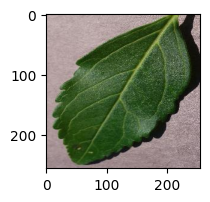

(16, 256, 256, 3)


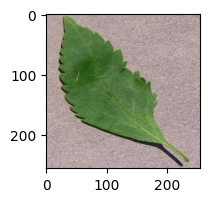

(16, 256, 256, 3)


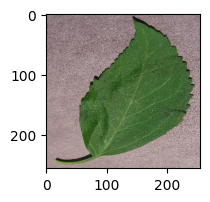

In [23]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

Save class_indices

In [24]:

joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model Creation

Import Packages

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad



ML Model

- The rationale for the model is explored in the README.md file of this project.
- This model answers the Business Requirement #2: it's the final version of the model upon which the predictions will be based

In [27]:
def create_tf_model():
    model = Sequential()

    ### input layer
    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ### convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))      
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    ### fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))

    ### output
    model.add(Dense(2, activation='softmax')) 

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adagrad',
                  metrics=['accuracy'])

    return model

Model Summary

In [28]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2024-11-18 01:05:23.989296: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Callbacks

Callbacks are a powerful feature in machine learning, particularly when training models using libraries like TensorFlow and Keras. They provide a mechanism to control and customize the training process, allowing users to take specific actions at various stages of the training lifecycle.

### EarlyStopping and ModelCheckPoint

- EarlyStopping is used to monitor the val_accuracy (validation accuracy).
- If the validation accuracy does not improve for a set number of epochs (patience=2 in your case), training will stop.
- This prevents overfitting, where the model becomes too specialized on the training data and performs poorly on unseen data (like validation or test sets).
--- 
- ModelCheckPoint monitors the val_accuracy and saves the model with the highest validation accuracy to the file path specified (outputs/v1/powdery_mildew_model.h5)
- This ensures that you have a copy of the best-performing model, which is crucial if you want to avoid retraining the model from scratch or in case of any interruptions during training.
- Saving only the best model also helps manage storage efficiently, especially if the training process runs for many epochs.

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1, patience=2)
m_checkpoint = ModelCheckpoint(filepath='outputs/v1/powdery_mildew_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

Fit Model for Model Training

In [30]:
model = create_tf_model()
model.fit(train_set,
          batch_size=batch_size,
          epochs=32,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop, m_checkpoint],
          verbose=1
          )

2024-11-18 01:07:06.318383: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/32
184/184 [==============================] - 211s 1s/step - loss: 0.5666 - accuracy: 0.7116 - val_loss: 0.5234 - val_accuracy: 0.7119
Epoch 2/32
184/184 [==============================] - 208s 1s/step - loss: 0.3474 - accuracy: 0.8458 - val_loss: 0.3028 - val_accuracy: 0.8762
Epoch 3/32
184/184 [==============================] - 209s 1s/step - loss: 0.3020 - accuracy: 0.8706 - val_loss: 0.2480 - val_accuracy: 0.9000
Epoch 4/32
184/184 [==============================] - 206s 1s/step - loss: 0.2626 - accuracy: 0.8964 - val_loss: 0.2641 - val_accuracy: 0.8833
Epoch 5/32
184/184 [==============================] - 203s 1s/step - loss: 0.2152 - accuracy: 0.9192 - val_loss: 0.1823 - val_accuracy: 0.9381
Epoch 6/32
184/184 [==============================] - 210s 1s/step - loss: 0.1829 - accuracy: 0.9351 - val_loss: 0.1499 - val_accuracy: 0.9452
Epoch 7/32
184/184 [==============================] - 204s 1s/step - loss: 0.1645 - accuracy: 0.9450 - val_loss: 0.1237 - val_accuracy: 0.9595

Save model

In [70]:
from keras.models import load_model

load_model('outputs/v1/powdery_mildew_model.h5')

---

Model Performance

Model Learning Curve A - Training, Validation, Loss & Accuracy Over Epochs

In [74]:

losses = pd.DataFrame(model.history.history)
plt.figure(figsize=(5, 4))
sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

KeyError: "None of [Index(['loss', 'val_loss'], dtype='object')] are in the [columns]"

<Figure size 500x400 with 0 Axes>

Model Learning Curve B - Loss & Accuracy Over Training Epochs

In [68]:

pd.DataFrame(model.history.history).plot(figsize=(8,5))
plt.savefig(f'{file_path}/model_loss_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

TypeError: no numeric data to plot


Model Learning Curve C - Loss & Accuracy Metrics of Model's Training Process Over Multiple Epochs

In [67]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Check for the existence of required keys in model history
required_keys = ['val_loss', 'loss', 'val_accuracy', 'accuracy']
available_keys = model.history.history.keys()

# Create the subplot with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces dynamically based on available keys
if 'val_loss' in available_keys:
    fig.add_trace(
        go.Scatter(y=model.history.history['val_loss'], name="Validation Loss"),
        secondary_y=False,
    )
if 'loss' in available_keys:
    fig.add_trace(
        go.Scatter(y=model.history.history['loss'], name="Training Loss"),
        secondary_y=False,
    )
if 'val_accuracy' in available_keys:
    fig.add_trace(
        go.Scatter(y=model.history.history['val_accuracy'], name="Validation Accuracy"),
        secondary_y=True,
    )
if 'accuracy' in available_keys:
    fig.add_trace(
        go.Scatter(y=model.history.history['accuracy'], name="Training Accuracy"),
        secondary_y=True,
    )

# Update layout and axis titles
fig.update_layout(
    title_text="Loss/Accuracy of LSTM Model",
    autosize=False,
    width=800,
    height=500,
)

fig.update_xaxes(title_text="Epoch")
fig.update_yaxes(title_text="<b>Primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>Secondary</b> Accuracy", secondary_y=True)

# Show the figure
fig.show()


fig.write_image(f'{file_path}/model_history.png')

ValueError: 
The orca executable is required to export figures as static images,
but it could not be found on the system path.

Searched for executable 'orca' on the following path:
    /home/gitpod/.pyenv/versions/3.8.18/bin
    /ide/bin/remote-cli
    /ide/bin/remote-cli
    /workspace/.pip-modules/bin
    /home/gitpod/.pyenv/bin
    /home/gitpod/.pyenv/shims
    /home/gitpod/.local/bin
    /usr/games
    /usr/local/sbin
    /usr/local/bin
    /usr/sbin
    /usr/bin
    /sbin
    /bin

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python


---

# Model Evaluation

### Import Packages

In [38]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

### Load Saved Model

In [39]:
from keras.models import load_model
model = load_model('outputs/v1/powdery_mildew_model.h5')

### Evaluate Model Accuracy

In [40]:

evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: ",evaluation[0])

53/53 [==============================] - 15s 281ms/step - loss: 0.0432 - accuracy: 0.9893
Model accuracy: 98.93%
Model Loss:  0.043180882930755615


### Set Accuracy Variable

In [41]:
validation_set.reset()

x_true, y_true = next(test_set)
preds = np.argmax(model.predict(test_set), axis=1)
y_pred = np.rint(preds)
y_true = test_set.labels

### ROC Currve

Area Under ROC-Curve:  0.9893364928909951


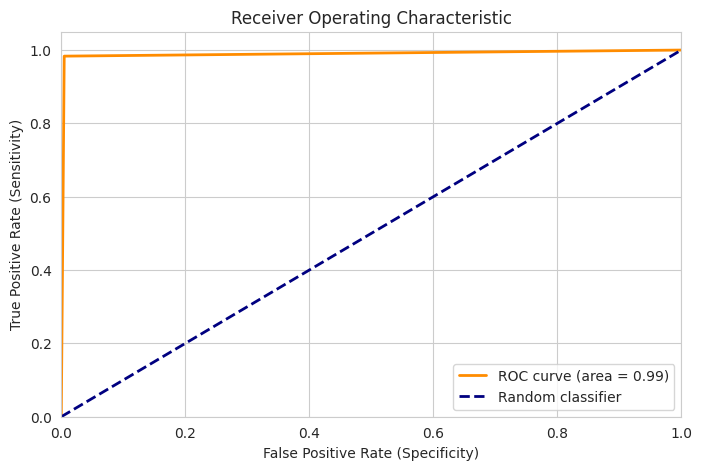

In [42]:
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score

sns.set_style("whitegrid")

fpr, tpr, _ = roc_curve(y_true, y_pred) # fpr: False Positive Rate, tpr: True Positive Rate
roc_auc = auc(fpr, tpr) # Calculate the Area Under the Curve (AUC) for the ROC curve

plt.figure(figsize=(8, 5))

lw = 2

plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, label="Random classifier", linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.title('Receiver Operating Characteristic')

plt.legend(loc="lower right")

plt.savefig(f'{file_path}/roccurve.png',
            bbox_inches='tight', dpi=150)
print('Area Under ROC-Curve: ', roc_auc_score(y_true, y_pred))
plt.show()

### Confusion Matrix

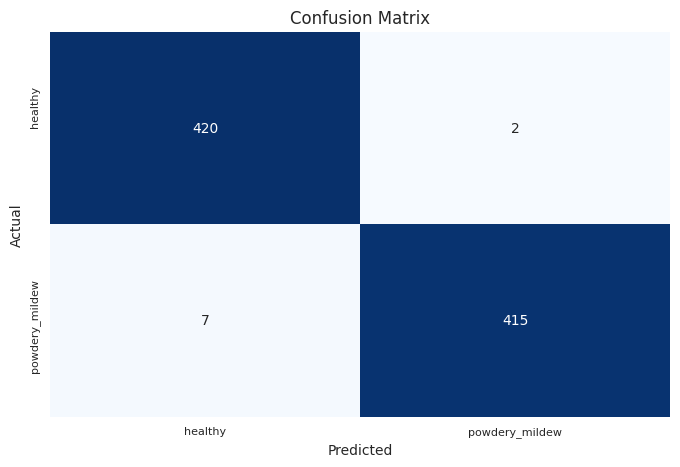

In [43]:

cm = confusion_matrix(y_true,y_pred)

classes=list(test_set.class_indices.keys()) 
length=len(classes)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(length)+.5, classes, rotation= 0, fontsize=8)
plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=8)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Classification Report - A

In [44]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [45]:
print('Classification Report:\n----------------------\n')
print(classification_report(y_true, y_pred, target_names=labels))

Classification Report:
----------------------

                precision    recall  f1-score   support

       healthy       0.98      1.00      0.99       422
powdery_mildew       1.00      0.98      0.99       422

      accuracy                           0.99       844
     macro avg       0.99      0.99      0.99       844
  weighted avg       0.99      0.99      0.99       844



### Classification Report - B

Text(0.5, 1.0, 'Classification Report')

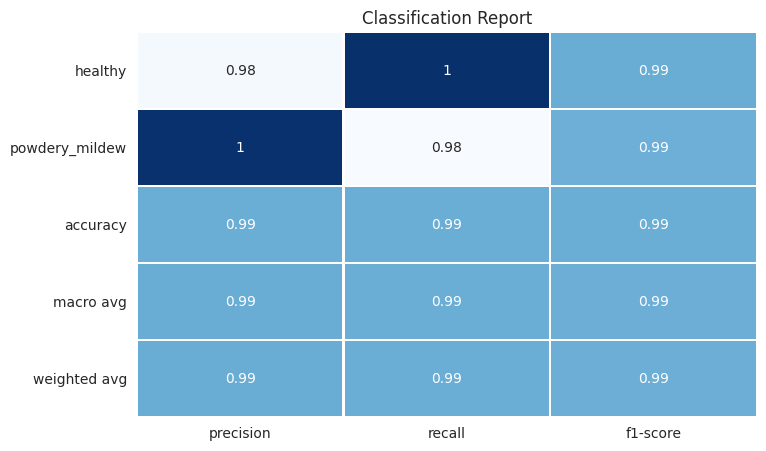

In [46]:
import matplotlib as mpl
clf_report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Blues", cbar=False, linewidths=1)
plt.title('Classification Report')

### Classificaiton Report - C

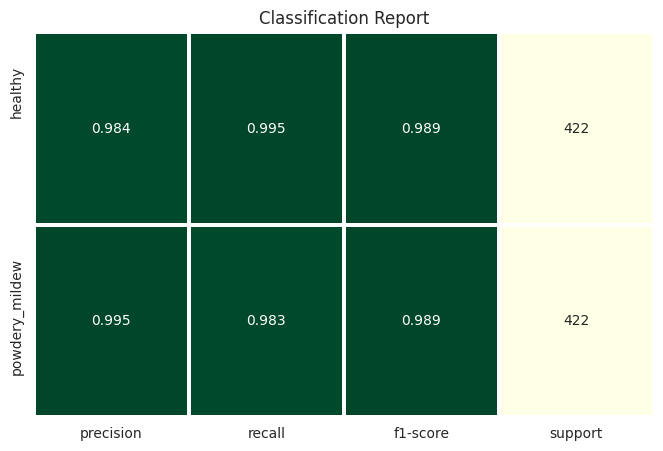

In [47]:
import matplotlib as mpl
import pathlib

def plot_classification_report(y_test, y_pred, title='Classification Report', save_fig_path=None, **kwargs):
    fig, ax = plt.subplots(figsize=(8,5))    
    clf_report = classification_report(y_true, y_pred, output_dict=True, **kwargs)
    keys_to_plot = [key for key in clf_report.keys() if key not in ('accuracy', 'macro avg', 'weighted avg')]
    df = pd.DataFrame(clf_report, columns=keys_to_plot).T
    df.sort_values(by=['support'], inplace=True) 
    
    rows, cols = df.shape
    mask = np.zeros(df.shape)
    mask[:,cols-1] = True
 
    ax = sns.heatmap(df, mask=mask, annot=True, cmap="YlGn", fmt='.3g', cbar=False,
            vmin=0.0,
            vmax=1.0,
            linewidths=.4, linecolor='white'
                    )
    
    mask = np.zeros(df.shape)
    mask[:,:cols-1] = True    
    
    ax = sns.heatmap(df, mask=mask, annot=True, cmap="YlGn", cbar=False,
            linewidths=2, linecolor='white', fmt='.0f',
            vmin=df['support'].min(),
            vmax=df['support'].sum(),         
            norm=mpl.colors.Normalize(vmin=df['support'].min(),
                                      vmax=df['support'].sum())
                    ) 
            
    plt.title(title)
    plt.yticks(np.arange(length)+.2, classes, rotation=90)
         
    if (save_fig_path != None):
        path = pathlib.Path(save_fig_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_fig_path)
    
    return fig, ax

fig, ax = plot_classification_report(y_true, y_pred, 
                    title='Classification Report',
                    target_names=labels,
                    save_fig_path = f'{file_path}/clf_report.png',)

Save Evaluation Pickle

In [48]:

joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

---

## Predict On New Data

Load Random Image as PIL

Image shape: (256, 256), Image mode: RGB


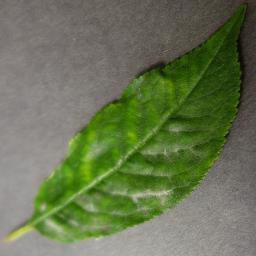

In [49]:

from tensorflow.keras.preprocessing import image

pointer = 32
label = labels[1] # select 0 for 'healthy' or 1 for 'powdery_mildew'

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert Image To Array & Prepare for Prediction

In [50]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)



Predict Class Probabilities

In [51]:

pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(f"{pred_class} {round(pred_proba*100, 2)}%")

powdery_mildew 99.1%
